# Collecting data and labelling with cellpose

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
FOLDER_NAME = "2024.05.09. Ac-kPHSRN+fibronektin"

!unzip "/content/drive/MyDrive/szakmai gyakorlat/{FOLDER_NAME}.zip" -d "/content"

In [3]:
%pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.0/205.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 11.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [4]:
import numpy as np
import glob
import cv2
import torch
from cellpose import models

# Loading the images.
file_names = glob.glob(FOLDER_NAME + "/*.jpg")

imgs = []
for name in file_names:
  img = cv2.imread(name, 0) # grayscale
  imgs.append(img)

# Using cyto3 cellpose model to label the images.
model = models.CellposeModel(model_type="cyto3", gpu=torch.cuda.is_available())

channels = [0, 0] # grayscale
flow_threshold = 0.4
cellprob_threshold = 0.0

masks, _, _ = model.eval(imgs, channels=channels, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)

In [5]:
# Only using average pixel intensity through the whole image as feature.
x = np.array([np.mean(img) for img in imgs])
y = np.array([np.max(mask) for mask in masks])

# Creating train and test datasets.
split_id = int(0.85 * len(x))
x_train, y_train = x[:split_id], y[:split_id]
x_test, y_test = x[split_id:], y[split_id:]

print(f"Train data points: {len(x_train)}")
print(f"Test data points: {len(x_test)}")

Train data points: 40
Test data points: 8


# Linear regression based on average intensity

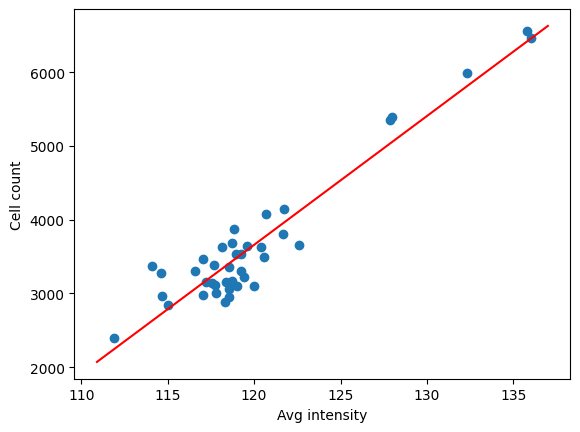

In [34]:
import matplotlib.pyplot as plt

# Linear regression to predict cell counts.
A = np.vstack([x_train, np.ones(len(x_train))]).T
m, c = np.linalg.lstsq(A, y_train, rcond=None)[0]

def f(x, m, c):
  return m * x + c

# Plotting the training data and results.
xs = np.arange(np.min(x_train)-1, np.max(x_train)+1, 0.1)
plt.xlabel("Avg intensity")
plt.ylabel("Cell count")
plt.scatter(x_train, y_train)
plt.plot(xs, f(xs, m, c), color="red");

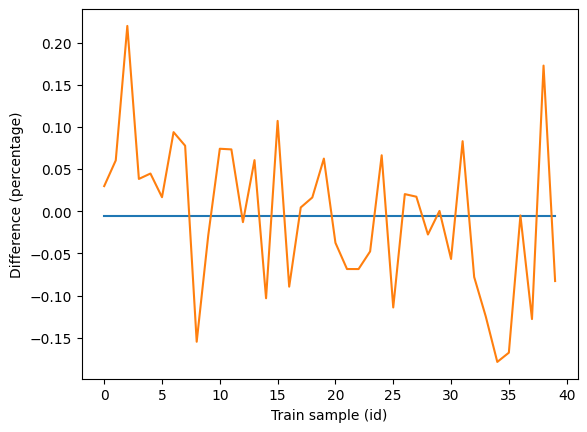

In [35]:
p_noise = (y_train - f(x_train, m, c)) / y_train
avg_p_noise = np.mean(p_noise)

plt.xlabel("Train sample (id)")
plt.ylabel("Difference (percentage)")
plt.plot([0, len(x_train)-1], [avg_p_noise, avg_p_noise])
plt.plot(np.arange(len(x_train)), p_noise);

In [36]:
mean_errors = (y_test - f(x_test, m, c)) ** 2
avg_mean_error = np.mean(mean_errors)
avg_deviation = np.mean(np.abs(y_test - f(x_test, m, c)))
print(f"Mean squared error on test dataset: {avg_mean_error}")
print(f"Average deviation: {avg_deviation}")

Mean squared error on test dataset: 40001.9249479642
Average deviation: 162.35860661489824


Worst mean error: 168804.01533956706
Actual: 3184, predicted: 2773.142341753781


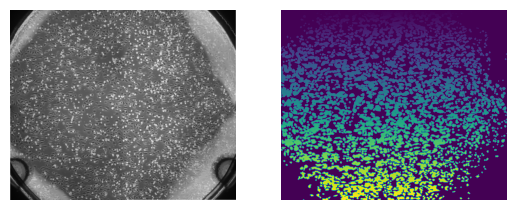

In [37]:
worst_id = split_id + np.argmax(mean_errors)

print(f"Worst mean error: {np.max(mean_errors)}")
print(f"Actual: {y[worst_id]}, predicted: {f(x[worst_id], m, c)}")

plt.subplot(121)
plt.axis("off")
plt.imshow(imgs[worst_id], cmap="gray")

plt.subplot(122)
plt.axis("off")
plt.imshow(masks[worst_id]);

In [45]:
# Saving model to a file.
import pickle

path = "/content/drive/MyDrive/szakmai gyakorlat/regression-cell-counting/models/avg_intensity_regression.pkl"

with open(path, "wb") as file:
  result = {
    "params": {
        "m": m,
        "c": c
    }
  }

  pickle.dump(result, file)